I have a panda pivot. I calculated centroids with kmeans previously, based on the rows which have all values filled. 
I want to use the same centroids to affect the rows.
For that I used this below distance 

def distance_to_centroid(row, centroid):
    # Calculate the sum of absolute differences, ignoring NaN values
    valid_indices = ~np.isnan(row)
    return np.sum(np.abs(row[valid_indices] - centroid[valid_indices]))

Now I want to consider that each row is a list of 2d points where x is the column index and y the value.
distance_to_centroid would return the sum, for each valid indices, of distances from row points to centroid points


# Objective

We will investigate the data by focusing on PA and PS (Heures pleines)
-> Kmeans clustering on maxPA/MaxPA_ALL (all months) + maxPS_ALL ((all months for installation) / maxPS (all installations)* factor

Try and create "configuration" and check


## we will calculate:

pa_df => PA and PS per Releve

anomalies_df => list anomalies

merged_df => pa_df with anomalies

aggregated_df_per_month => pivot table installation/months => value is maxPA/maxPS

cluster_df => Installation + cluster

## Useful functions

def get_information_from_cluster(pa_df,cluster_id)




# Import libraries, paths and tools

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from collections import Counter
import seaborn as sns
import os
import random
pd.options.display.float_format = '{:.2f}'.format

In [30]:
#data repository
data_dir = Path(r'/Users/michaelargi/projects/perso/unsupervised/2024_05_13_config')
folder_path = data_dir

data_paths = {
    'pa_ps':'PA_PS_Installation.csv',
    'ps':'PS_par_Installation.csv',
    'combined_data_month':'combined_data_month.csv',
    'anomalies':'Ano_112022au022024.csv',
    'aggregated_df_per_month_merged_with_ano':'Installation_PA_PS_ANO.csv',
    'aggregated_df_per_month':'aggregated_df_per_month.csv',
    'installation_cluster':'installation_cluster.csv',
    'pivot_ouliers':'pivot_ouliers.csv',
    'configuration_cluster':'configuration_cluster.csv',
    'train':'train.csv',
    'test':'test.csv',
    'validation':'validation.csv',
    'cleaned':'tmp/data_cleaned.csv',
    'ready':'tmp/data_ready.csv',
    'X_train':'tmp/train_features.csv',
    'y_train':'tmp/train_target.csv',
    'X_val':'tmp/val_features.csv',
    'y_val':'tmp/val_target.csv',
    'X_train_processed':'tmp/train_features_processed.csv',
    'X_val_processed':'tmp/val_features_processed.csv',
    'check':'tmp/check.csv',
    'dayoffs':'DAY_OFFS.csv'
}



In [31]:
class Environment:
    max_nb_clusters=200
    clustering_algorithm="Agg"#Agg, Dtw Kmeans
    max_deviance_agg=30
    min_nb_in_cluster=10
    delete_rows_PA_SUP_PS=False
    target_column_name = "Revised"
    should_rename_columns= False
    should_bin=False
    num_bins = 5
    nb_binning_limit = 20
    binned_suffix = "_BINNED"
    show_graphs = False
    should_normalize = False
    final_normalization= False
    def todict(self):
      return{
          "max_nb_clusters":self.max_nb_clusters,
          "clustering_algorithm":self.clustering_algorithm,
          "max_deviance_agg":self.max_deviance_agg,
          "min_nb_in_cluster":self.min_nb_in_cluster,
          'delete_rows_PA_SUP_PS':self.delete_rows_PA_SUP_PS,
          "target_column_name":self.target_column_name,
          "should_rename_columns":self.should_rename_columns,
          "should_bin":self.should_bin,
          "num_bins":self.num_bins,
          "nb_binning_limit": self.nb_binning_limit,
          "binned_suffix" :self.binned_suffix,
          "show_graphs" :self.show_graphs,
          "should_normalize" :self.should_normalize,
          "final_normalization": self.final_normalization
      }


ENV= Environment()


In [32]:
import csv,json
from datetime import datetime

def create_result_folder():
  prefix="results_"
  now = datetime.now()
  time_str = now.strftime("%Y%m%d_%H%M%S")
  folder_name = f"{prefix}{time_str}"
  folder_path = os.path.join(data_dir, folder_name)
  os.mkdir(folder_path)
  return folder_path

#folder_path=create_result_folder()

#save dict in file
def saveDictInFile(dict, file_name):
    print("saveDictInFile")
    os.makedirs(folder_path, exist_ok=True)
    csv_file_path = os.path.join(folder_path, file_name)
    with open(csv_file_path, "w", newline="") as fp:
      writer = csv.DictWriter(fp, fieldnames=dict.keys())
      writer.writeheader()
      writer.writerow(dict)

#save list in file
def write_list(a_list,file_name):
  csv_file_path = os.path.join(folder_path, file_name)
  df = pd.DataFrame(a_list)
  dataframe_to_csv(df,csv_file_path)

#Save dataframe to csv
def dataframe_to_csv(df,file_name):
  csv_file_path = os.path.join(folder_path, file_name)
  df.to_csv(csv_file_path, index=False)
    
def pivot_to_csv(pivot_df,file_name):
  csv_file_path = os.path.join(folder_path, file_name)
  pivot_df.to_csv(csv_file_path, index=True, header=True)

def generate_name_based_on_time(prefix="Name_", suffix=""):
    now = datetime.now()
    time_str = now.strftime("%Y%m%d_%H%M%S")
    name = f"{prefix}{time_str}{suffix}"
    return name

saveDictInFile(ENV.todict(),"env.csv")

#result_file_name = "results.csv"

saveDictInFile


In [33]:
#utils
def encode_columns(data_frame, verbose=False):
  #Encoding
  label_encoder = LabelEncoder()
  for column in data_frame.columns:
      if column == ENV.target_column_name:
        data_frame[ENV.target_column_name] = data_frame[ENV.target_column_name].astype(int)
        if verbose:
          print("Don't encode target, we convert to int")
        continue
      if data_frame[column].dtype == 'object':  # Check if the column is of type 'object' (string)
          data_frame[column] = label_encoder.fit_transform(data_frame[column])
      elif data_frame[column].dtype == 'bool':
          data_frame[column].replace({True: 1, False: 0},inplace=True)
      else:
        if verbose:
          print("encode_columns error "+column+" ")
        #print(data_frame[column].dtype)


def drop_columns(data_frame,columns_to_drop, verbose=False):
  data_frame_copy = data_frame.copy()
  for column in columns_to_drop:
    if column in data_frame_copy.columns:
        if verbose:
            print("dropping column")
        data_frame_copy.drop(columns=column, inplace=True)
    else:
        if verbose:
            print(f"Column '{column}' does not exist in the DataFrame.")
  return data_frame_copy

In [34]:
def is_key_column(col):
  nb_unique_values = col.nunique()
  return nb_unique_values>100 and  nb_unique_values/col.count()>0.7

def is_binnable(col,nb_bins):
  nb_unique_values = col.nunique()
  return nb_unique_values>nb_bins and nb_unique_values> ENV.nb_binning_limit

def normalize(df:pd.DataFrame, col_name:str, factor):
  min = df[col_name].min()
  max = df[col_name].max()
  df[col_name]=(df[col_name]-min)/(max - min) * factor

#Clear folder's content, delete all file inside
def clear_folder(folder_path):
  files = os.listdir(folder_path)
  for file in files:
      file_path = os.path.join(folder_path, file)
      if os.path.isfile(file_path):
          os.remove(file_path)



In [35]:
#binning
from sklearn.tree import DecisionTreeRegressor

def create_bin_column(df:pd.DataFrame,column:str,num_bins:int, optional_bin_edges = None, verbose = False):
  if column == ENV.target_column_name:
    return

  if verbose:
    print("binning "+column)
  col = df[column]
  target_column_name= ENV.target_column_name
  target = df[target_column_name]
  if verbose:
    print("min",col.min())
    print("max",col.max())
  if col.nunique() <= num_bins:
    if verbose:
      print("too few for binning, returning")
    return
  if(optional_bin_edges):
    bin_edges = optional_bin_edges
  else:
    nb_leaves= num_bins
    tree = DecisionTreeRegressor(max_leaf_nodes=nb_leaves )
    tree.fit(df[[column]], target)

    # Use the decision tree to assign each data point to a bin
    bin_edges = tree.tree_.threshold[tree.tree_.feature != -2]

    # You might want to add the minimum and maximum edges
    bin_edges = np.concatenate(([col.min()], bin_edges, [col.max()]))
    if verbose:
      print(bin_edges)

    # Sort the array to ensure correct order of bin edges
    bin_edges.sort()

  # Print bin edges
  if verbose:
    print("Bin edges:", bin_edges)

  df[column + ENV.binned_suffix] = pd.cut(df[column], bins=bin_edges, include_lowest=True, labels=range(num_bins))

  return bin_edges


In [36]:
def transform_column_name(name):
    # Remove trailing spaces, replace special characters with underscores, and convert to capital letters
    return name.strip().replace(' ', '_').replace('@', '_').upper()

# Function to get pa data, from csv or xlsx

In [37]:
def replace_dots_and_commas(value):
    if ',' in value:
        return value.replace('.', '').replace(',', '.')
    else:
        return value
        
def make_float(column):
    column = column.apply(replace_dots_and_commas)
    #column = column.str.split(',').str[0]  # This keeps '218.3' as is and changes '1.500,000' to '1.500'
    column = pd.to_numeric(column, errors='coerce') 
    return column

In [38]:
def get_ps_per_installation():
    ps_path = os.path.join(folder_path,data_paths['ps'])

    ps_par_installation = pd.read_csv(ps_path,low_memory=False)
    ps_par_installation['PS']= make_float(ps_par_installation['PS'])
    print(ps_par_installation.columns)
    print(ps_par_installation.dtypes)

    eternity = "31/12/9999" #eternity is far away
    ps_par_installation['Fin_validite'] = ps_par_installation['Fin_validite'].replace('31/12/9999', '31/12/2024')

    ps_par_installation['Debut_validite']=pd.to_datetime(ps_par_installation['Debut_validite'], format='%d/%m/%Y')
    ps_par_installation['Fin_validite']=pd.to_datetime(ps_par_installation['Fin_validite'], format='%d/%m/%Y')
    return ps_par_installation
    
ps_par_installation = get_ps_per_installation()

Index(['Installation', 'Debut_validite', 'Fin_validite', 'PS'], dtype='object')
Installation        int64
Debut_validite     object
Fin_validite       object
PS                float64
dtype: object


In [39]:
def get_pa_data(regenerate = False):
    print("get_pa_data")
    export_path = os.path.join(folder_path,data_paths['pa_ps'])
    
    columns_to_drop=['PS','Conso_COSY','Unitée']
    dtype_spec = {'PA':'string','Nom_Cadran_PA':'string','Code_NAF':'string','REGION':'string'}
    
    def export_pa():
        print("export_pa")
        column_name_mapping = {
            'Date_relevé': 'Date_de_releve',
            'Numéro_relevé': 'Numero_releve',
            'Num_Cadran':'Numero_Cadran_PA',
            'Index':'PA',
        }
        ps_par_installation = get_ps_per_installation()
        rl_folder_path = os.path.join(data_dir, 'ML_Export_rlv')
        data_frames = []
        for filename in os.listdir(rl_folder_path):
            if filename.endswith('.csv'):
                print("adding "+filename)
                file_path = os.path.join(rl_folder_path, filename)
                #print(file_path)
                df = pd.read_csv(file_path,dtype=dtype_spec, encoding='ISO-8859-1', low_memory=False, sep=";")
                #print(df.columns)
                df.columns = df.columns.str.replace(' ', '', regex=False)
                df = drop_columns(df,columns_to_drop)
                if set(column_name_mapping.keys()).intersection(df.columns):
                    df.rename(columns=column_name_mapping, inplace=True)
                #na_counts_before = df['Puissance_souscrite'].isna().sum()
                #df['PA']=make_float(df['PA'])
                data_frames.append(df)
        combined_df = pd.concat(data_frames, ignore_index=True)
        print("COMBINED")
        print(combined_df.columns)
        
        #only Heures Pleines, keep only Nom_Cadran_PA with S_PA_HPH or S_PA_HPE or S_PA_HP
        combined_df = combined_df.loc[combined_df['Nom_Cadran'].isin(['S_PA_HPH', 'S_PA_HPE','S_PA_HP'])]
        
        print("Generating new columns")
        combined_df['Cadran_key'] = combined_df['Installation'].astype(str) + "_" + combined_df['Numero_Cadran_PA'].astype(str)
        combined_df['Date_de_releve']=pd.to_datetime(combined_df['Date_de_releve'], format='%Y%m%d')
        merged_df = pd.merge(combined_df, ps_par_installation, on='Installation', how='left')
        print(merged_df.columns)
        print(f'nb merged_df {len(merged_df)}')
        print(merged_df.head())
        # Filtering to find rows where Date_de_releve is within the Debut_validite and Fin_validite range
        result_df = merged_df[(merged_df['Date_de_releve'] >= merged_df['Debut_validite']) & 
                              (merged_df['Date_de_releve'] <= merged_df['Fin_validite'])]
        result_df['month'] = result_df['Date_de_releve'].dt.strftime('%Y-%m')
        # Selecting required columns
        combined_df = result_df[['Installation', 'Code_NAF','REGION','Numero_Cadran_PA','Cadran_key','Date_de_releve','month','PA','PS']]
        print(combined_df.columns)
        #df.rename(columns=transform_column_name, inplace=True)
        combined_df.sort_values(by=['Cadran_key', 'Date_de_releve'], inplace=True)
        print(f'nb releves final {len(combined_df)}')
        combined_df['PA'] = combined_df['PA'].astype(float)
        combined_df['PS'] = combined_df['PS'].astype(float)

        dataframe_to_csv(combined_df, data_paths['pa_ps'])
        return combined_df
        
    if os.path.isfile(export_path) and not regenerate:
        pa_df = pd.read_csv(export_path,dtype=dtype_spec,low_memory=False)
    else:
        pa_df = export_pa()
    
    print("reformating")
    print(pa_df.dtypes)
    pa_df['Date_de_releve']=pd.to_datetime(pa_df['Date_de_releve'], format='%Y-%m-%d')
    pa_df['month']= pa_df['month'].astype('string')
    pa_df['Cadran_key']= pa_df['Cadran_key'].astype('string')
    pa_df['PA'] = pa_df['PA'].astype(float)
    print(f'nb releves consolidated {len(pa_df)}')
    print(pa_df.head())

    return pa_df

pa_df = get_pa_data()

'''
unique_months = pa_df['month'].unique()
unique_months_list = unique_months.tolist()
print(unique_months_list)
'''
print(pa_df.columns)
print(pa_df.dtypes)

get_pa_data
reformating
Installation          int64
Code_NAF             string
REGION               string
Numero_Cadran_PA      int64
Cadran_key           object
Date_de_releve       object
month                object
PA                   string
PS                  float64
dtype: object
nb releves consolidated 4064858
   Installation Code_NAF REGION  Numero_Cadran_PA Cadran_key Date_de_releve  \
0        292561    9601B    211                47  292561_47     2022-10-11   
1        292561    9601B    211                47  292561_47     2022-11-11   
2        292561    9601B    211                47  292561_47     2022-12-11   
3        292561    9601B    211                47  292561_47     2023-01-11   
4        292561    9601B    211                47  292561_47     2023-02-11   

     month    PA    PS  
0  2022-10  0.00 95.00  
1  2022-11 91.00 95.00  
2  2022-12 89.00 95.00  
3  2023-01 88.00 95.00  
4  2023-02 64.00 95.00  
Index(['Installation', 'Code_NAF', 'REGION', 'Numero_

In [40]:
def get_anomalies():
    #Num_ANO,Num_releve,Installation,PRM,Date d'origine de l'anomalie ,Date de releve,Num_Cadran,Index
    file_path = os.path.join(folder_path,data_paths['anomalies'])
    print(file_path)
    column_name_mapping = {
        "Date de releve": 'Date_de_releve',
        'Numéro_relevé': 'Numero_releve',
    }
    columns_to_drop=['PRM',"Date_anomalie",'Index','Num_releve']
    dtype_spec = {}
    df = pd.read_csv(file_path,dtype=dtype_spec, low_memory=False)
    print(df.head())
    if set(column_name_mapping.keys()).intersection(df.columns):
        df.rename(columns=column_name_mapping, inplace=True)
    df['Date_de_releve']=pd.to_datetime(df['Date_de_releve'], format='%Y%m%d')
    df = drop_columns(df,columns_to_drop)

    print(df.columns)
    print(df.dtypes)
    print(df.head())
    return df
    
anomalies_df=get_anomalies()
merged_df = pd.merge(pa_df, anomalies_df, on=['Installation','Date_de_releve'], how='left')
columns_to_drop=['Code_NAF','REGION']
merged_df = drop_columns(merged_df,columns_to_drop)

print(merged_df.columns)


nb_rows = len(merged_df)
nb_matched_anomalies = nb_rows- merged_df['Num_ANO'].isna().sum()

print(f'matched {nb_matched_anomalies} out of {nb_rows} having {len(anomalies_df)}')

found_anomalies = merged_df[merged_df['Num_ANO'].notna() & (merged_df['Num_ANO'] != '')]
print(found_anomalies.head(5))
    

/Users/michaelargi/projects/perso/unsupervised/2024_05_13_config/Ano_112022au022024.csv
   Num_ANO  Num_releve  Installation             PRM  Date_anomalie  \
0  7815922  3978857180        292594  30001421871154       20230519   
1  7859984  4021838299        292594  30001421871154       20230618   
2  7903216  4065591696        292594  30001421871154       20230719   
3  7946332  4109231587        292594  30001421871154       20230819   
4  7988586  4152925109        292594  30001421871154       20230918   

   Date_de_releve  Num_Cadran       Index  
0        20230518           9      47.547  
1        20230617           9      48.756  
2        20230718           9      50.043  
3        20230818           9      51.117  
4        20230917           9      52.377  
Index(['Num_ANO', 'Installation', 'Date_de_releve', 'Num_Cadran'], dtype='object')
Num_ANO                    int64
Installation               int64
Date_de_releve    datetime64[ns]
Num_Cadran                 int64
dtype:

# First view of data



In [41]:
show_describe= True
 
if ENV.should_rename_columns:
  pa_df.rename(columns=transform_column_name, inplace=True)
  ENV.target_column_name = ENV.target_column_name.upper()

if show_describe:
    print("\nhead")
    print("=" * 40)
    print(pa_df.head(5))
    
    print("\tail")
    print("=" * 40)
    print(pa_df.tail(5))
    
    print('This is the Shape of the data')
    print('='*49)
    print("The total number of columns: ", pa_df.shape[1])
    print("The total number of rows: ", pa_df.shape[0])
    print('='*49)

    print('\nTypes of the Dataset:')
    print("=" * 40)
    print(pa_df.dtypes)

    print('\nDescription of the numerical Dataset:')
    print("=" * 40)
    numerical_description = pa_df.describe(include=['int', 'float']).T
    print(numerical_description)
    
    if any(pa_df.dtypes == 'object') or any(pa_df.dtypes == 'bool'):
        print('\nDescription of the Categorical Dataset:')
        print("=" * 40)
        categorical_description = pa_df.describe(include=['object', 'bool']).T
        print(categorical_description)

    print('\nDescription of the nb values:')
    print("=" * 40)
    value_counts_per_column = pa_df.nunique()

    # Convert the Series to a DataFrame for better table display
    value_counts_df = value_counts_per_column.reset_index()
    print(value_counts_df)

    print("\nis null")
    print("=" * 40)
    print(pa_df.isnull().sum())
    
    print("\nis nan")
    print("=" * 40)
    print(pa_df.isna().sum())



head
   Installation Code_NAF REGION  Numero_Cadran_PA Cadran_key Date_de_releve  \
0        292561    9601B    211                47  292561_47     2022-10-11   
1        292561    9601B    211                47  292561_47     2022-11-11   
2        292561    9601B    211                47  292561_47     2022-12-11   
3        292561    9601B    211                47  292561_47     2023-01-11   
4        292561    9601B    211                47  292561_47     2023-02-11   

     month    PA    PS  
0  2022-10  0.00 95.00  
1  2022-11 91.00 95.00  
2  2022-12 89.00 95.00  
3  2023-01 88.00 95.00  
4  2023-02 64.00 95.00  
	ail
         Installation Code_NAF REGION  Numero_Cadran_PA Cadran_key  \
4064853        524304    6832A    211                52  524304_52   
4064854        524304    6832A    211                52  524304_52   
4064855        524304    6832A    211                52  524304_52   
4064856        524304    6832A    211                52  524304_52   
4064857       

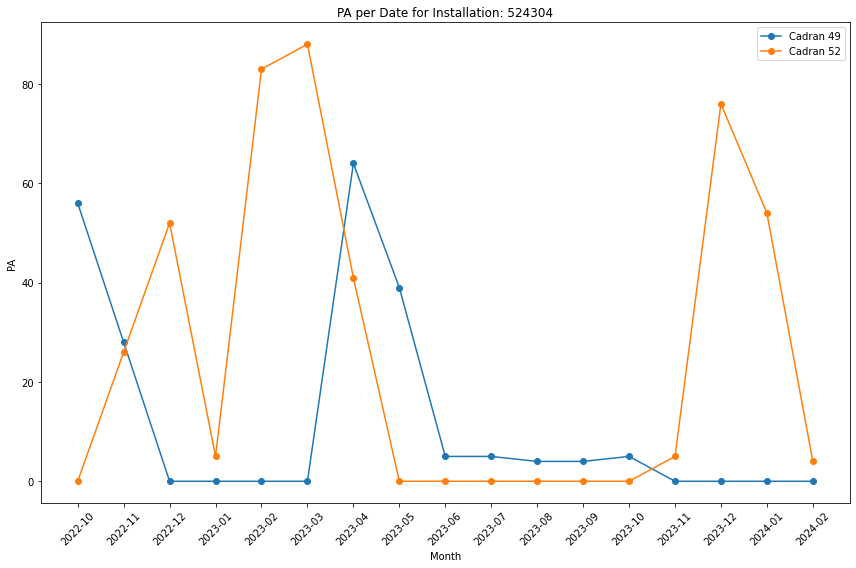

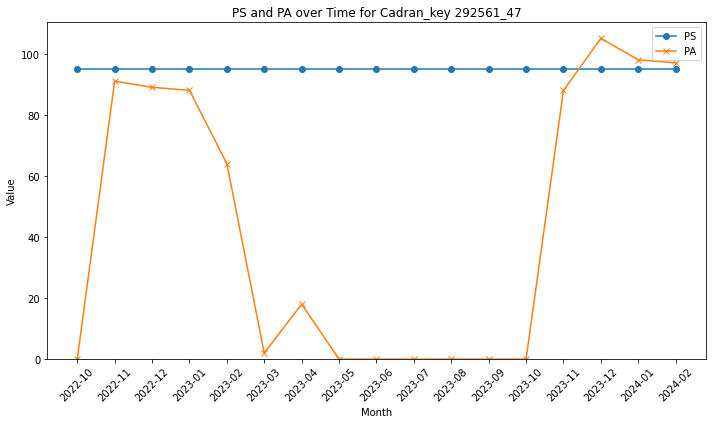

In [42]:
def plot_PA_per_date_for_installation(df, installation,saveName=""):
    filtered_df = df[df['Installation'] == installation]
    # Get unique 'Cadran' values
    cadran_values = filtered_df['Numero_Cadran_PA'].unique()
    plt.figure(figsize=(12, 8))  # Adjust figure size as needed
    # Loop through each 'Cadran' value and plot
    for cadran in cadran_values:
        subset_df = filtered_df[filtered_df['Numero_Cadran_PA'] == cadran]
        plt.plot(subset_df['month'], subset_df['PA'], marker='o', label=f'Cadran {cadran}')
    
    plt.title(f'PA per Date for Installation: {installation}')
    plt.xlabel('Month')
    plt.ylabel('PA')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    if saveName:
        plt.savefig(saveName)
        plt.close()
    else:
        plt.show()


plot_PA_per_date_for_installation(pa_df,524304)

def plot_PA_AND_PS_per_date_for_Cadran(df, cadran_key):
    cadran_key = str(cadran_key)
    specific_cadran_df = df[df['Cadran_key'] == cadran_key]
    plt.figure(figsize=(10, 6))
    plt.plot(specific_cadran_df['month'], specific_cadran_df['PS'], label='PS', marker='o')  # PS line
    plt.plot(specific_cadran_df['month'], specific_cadran_df['PA'], label='PA', marker='x')  # PA line
    plt.ylim(bottom=0) 
    # Formatting the plot
    plt.title(f'PS and PA over Time for Cadran_key {cadran_key}')
    plt.xlabel('Month')
    plt.ylabel('Value')
    plt.xticks(rotation=45)  # Rotate dates for better readability
    plt.legend() 
    plt.tight_layout()
    plt.show()


plot_PA_AND_PS_per_date_for_Cadran(pa_df,'292561_47')
    


def print_Date_de_Releve_for_Cadran_key(df, specific_cadran_key):
    filtered_df = df[df['Cadran_key'] == specific_cadran_key]
    print(filtered_df['Date_de_releve'])
    
#print_Date_de_Releve_for_Cadran_key(consolidated_df,'41036856101_1')


    


# Clustering

## Agregation per Installation/Month and instertion maxPA/MaxPS

In [43]:
def get_aggregated_data_per_month(regenerate = False):
    export_path = os.path.join(folder_path,data_paths['combined_data_month'])
    print("get_aggregated_data_per_month from "+export_path)
    columns_to_drop=['']
    #dtype_spec = {'PS': 'string','PA':'string','Nom_Cadran_PA':'string'}
    
    def export():
        df = get_pa_data()
        print(df.columns)
        print("export")
        column_name_mapping = {
        }
        #aggregate on Installation and month
        aggregated = df.groupby(['Installation', 'month']).agg(
            PAInstallationMonth=('PA', 'max'),
            PSInstallationMonth=('PS', 'max'),
            Code_NAF=('Code_NAF', 'first'),  # Takes the first occurrence
            REGION=('REGION', 'first') 
        ).reset_index()

        #Calculate max PA, PS par Installation
        maxPAInstallation = aggregated.groupby('Installation')['PAInstallationMonth'].max().reset_index()
        maxPAInstallation.rename(columns={'PAInstallationMonth': 'maxPAInstallation'}, inplace=True)
        maxPSInstallation = aggregated.groupby('Installation')['PSInstallationMonth'].max().reset_index()
        maxPSInstallation.rename(columns={'PSInstallationMonth': 'maxPSInstallation'}, inplace=True)
        aggregated = aggregated.merge(maxPAInstallation, on='Installation')
        aggregated = aggregated.merge(maxPSInstallation, on='Installation')

        #Calculate maxPAmonth/maxPAInstallation
        aggregated['maxPANormalized']=aggregated['PAInstallationMonth']/aggregated['maxPAInstallation']
        aggregated['maxPSNormalized']=aggregated['PSInstallationMonth']/aggregated['maxPSInstallation']
        
        #Final ratio we intend to use :
        aggregated['PA_div_PS_Normalized']=aggregated['maxPANormalized']/aggregated['maxPSNormalized']
        
        #Now add Normalized PS (PS/Max all PS and renormalize)
        maxPS =aggregated["PSInstallationMonth"].max() 
        print(f'max PS is {maxPS}')
        scaler = StandardScaler()
        aggregated['PS_Normalized'] = scaler.fit_transform(aggregated[['PSInstallationMonth']])
        
        
        print(aggregated.columns)
        print(aggregated.head(2))
        print(aggregated.dtypes)
        dataframe_to_csv(aggregated, data_paths['combined_data_month'])
        return aggregated
        
    if os.path.isfile(export_path) and not regenerate:
        aggregated = pd.read_csv(export_path,low_memory=False)
        aggregated = drop_columns(aggregated,columns_to_drop)
    else:
        aggregated = export()
    
    print("Removing Installations with maxPAInstallation == 0")
    nb_rows_before = len(aggregated)
    non_zero_filter = aggregated['maxPAInstallation'] > 0
    aggregated['ratio_cluster']=aggregated['maxPANormalized']
    aggregated = aggregated[non_zero_filter]
    nb_rows_after = len(aggregated)
    nb_removed = nb_rows_before - nb_rows_after
    print(f'Removed {nb_removed} lines. This is number of Installation at issue x their months in datafarame')
    
    return aggregated

aggregated_df_per_month = get_aggregated_data_per_month()
print(f'nb Installation x months is {len(aggregated_df_per_month)}')

merged=pd.merge(aggregated_df_per_month, found_anomalies, on=['Installation','month'], how='left')
dataframe_to_csv(merged, data_paths['aggregated_df_per_month_merged_with_ano'])

def get_ANO_per_Installation(installation):
    filtered_df = merged[merged['Installation']==installation & merged['Num_ANO'].notna()]
    grouped = filtered_df.groupby('month')['Num_ANO'].agg(list).reset_index()
    # Convert grouped data to dictionary {month: list of Num_ANO}
    result_dict = dict(zip(grouped['month'], grouped['Num_ANO']))
    return result_dict

#print(merged_df.columns)
#print(merged_df.head())



get_aggregated_data_per_month from /Users/michaelargi/projects/perso/unsupervised/2024_05_13_config/combined_data_month.csv
Removing Installations with maxPAInstallation == 0
Removed 6233 lines. This is number of Installation at issue x their months in datafarame
nb Installation x months is 2022922


## Creating a pivot table with Installation as index and months as columns

In [44]:
# like a pivot table in XL=> month in columns 
pivot_df = aggregated_df_per_month.pivot(index='Installation', columns='month', values='ratio_cluster')
print(pivot_df.columns)
print(f'Total number installations in pivot table {len(pivot_df)}')

Index(['2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
       '2023-10', '2023-11', '2023-12', '2024-01', '2024-02'],
      dtype='object', name='month')
Total number installations in pivot table 123250


## Detele all rows where at least one value >1 (PA>PS)

In [45]:
# should we delete rows where PA>PS ? => no in standard cases
if ENV.delete_rows_PA_SUP_PS:
    print("deleting cases where PA>PS")
    mask = (pivot_df > 1).any(axis=1)
    pivot_df = pivot_df[~mask]
    print(f'nb Lines {len(pivot_df)}')

## Filtering Installation with data for all months

In [46]:
pivot_df_with_all_months = pivot_df.dropna().copy()
print(f'nb installation with values for all months :{len(pivot_df_with_all_months)}')

nb installation with values for all months :83060


## Let's clusterize these Installations with data for all months 

In [47]:
#graph functions to show clusters
def plot_centroid(id,months,cluster_centers):
    values = cluster_centers[id]
    plt.figure(figsize=(10, 6))
    plt.plot(months, values, label='Centroid ', marker='o', linestyle='-', color='blue')
    # Formatting the plot
    plt.title(f'Centroid Values Over Time for centroid {id}')
    plt.ylim(bottom=0) 
    plt.xlabel('Month')
    plt.ylabel('Centroid Value')
    plt.xticks(months, labels=months, rotation=45)  # Set x-ticks labels explicitly if needed
    plt.legend()

    plt.tight_layout()  # Adjust layout to make room for the rotated x-tick labels
    plt.show()

def plot_centroid_with_installations(id, months, cluster_centers, pivot_df_with_all_months):
    values = cluster_centers[id]
    plt.figure(figsize=(10, 6))
    plt.plot(months, values, label='Centroid', marker='o', linestyle='-', color='blue')

    # Filter DataFrame for installations in the specific cluster
    installation_rows = pivot_df_with_all_months[pivot_df_with_all_months['cluster'] == id]

    # Iterate over each installation's row
    for index, row in installation_rows.iterrows():
        plt.plot(months, row[months], label=f'Installation {index}', marker='x', linestyle='--')

    # Formatting the plot
    plt.title(f'Centroid Values Over Time for centroid {id}')
    plt.ylim(bottom=0)
    plt.xlabel('Month')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    #plt.legend()

    plt.tight_layout()  # Adjust layout to make room for the rotated x-tick labels
    plt.show()

clusterizing step
Index(['2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
       '2023-10', '2023-11', '2023-12', '2024-01', '2024-02'],
      dtype='object', name='month')
Clusterising with Agg
Clusterizing with clusterize_Agg, 30 distance_threshold.


/Users/michaelargi/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:280: UserWarning: the number of connected components of the connectivity matrix is 37 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


Cluster centers columns:
Index(['2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
       '2023-10', '2023-11', '2023-12', '2024-01', '2024-02'],
      dtype='object', name='month')
Cluster centers:
[[0.84963451 0.81881732 0.78686785 ... 0.77987491 0.76897398 0.77332958]
 [0.63368306 0.63067593 0.6926863  ... 0.6702394  0.65097438 0.67654764]
 [0.35018066 0.41559558 0.82223466 ... 0.17172491 0.13938753 0.14389717]
 ...
 [0.97764871 0.2604663  0.27729199 ... 0.20207222 0.19530393 0.2369215 ]
 [0.84089812 0.83247711 0.88221305 ... 0.85723288 0.84028365 0.86564533]
 [0.57127126 0.71045659 0.66696461 ... 0.71573662 0.58747089 0.61609181]]
nb centroids 162
Cluster 125: 32 Installations
Cluster 151: 39 Installations
Cluster 90: 54 Installations
Cluster 154: 56 Installations
Cluster 136: 58 Installations
Cluster 126: 58 Installations
Cluster 100: 58 Installations
Cluster 133: 59 Installations
Cluster 109: 

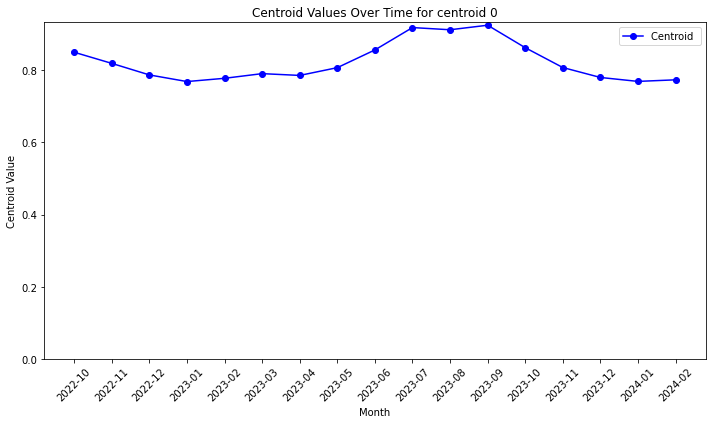

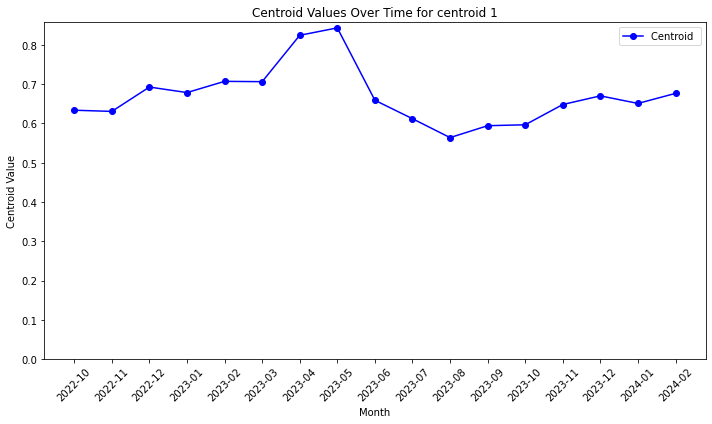

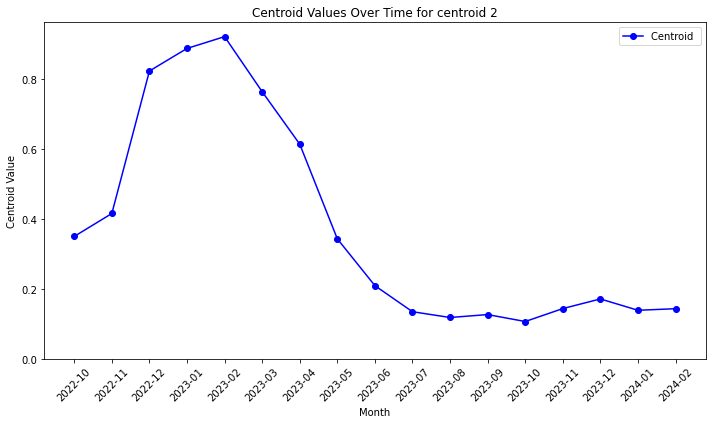

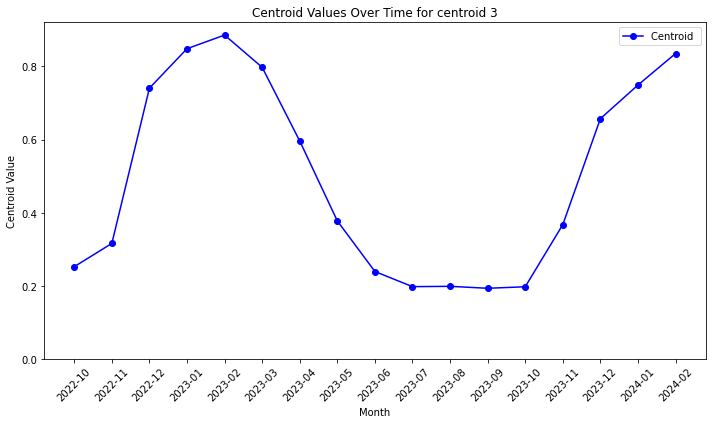

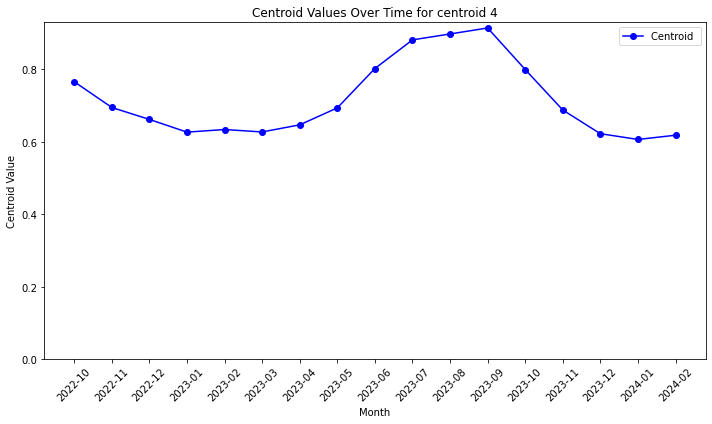

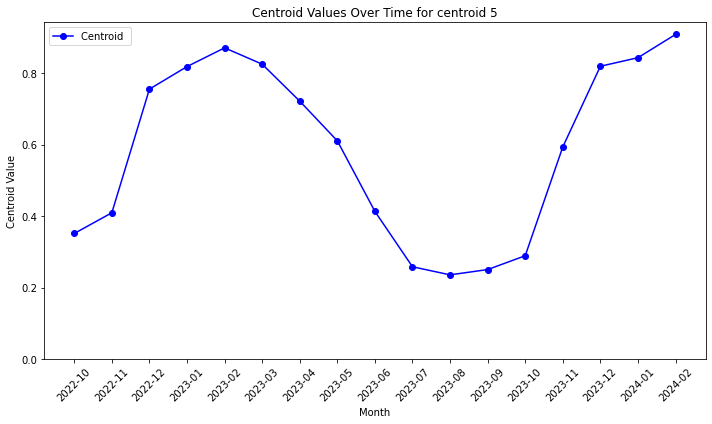

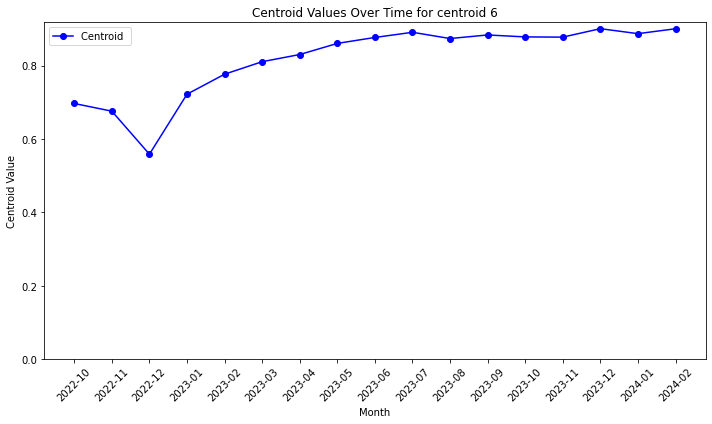

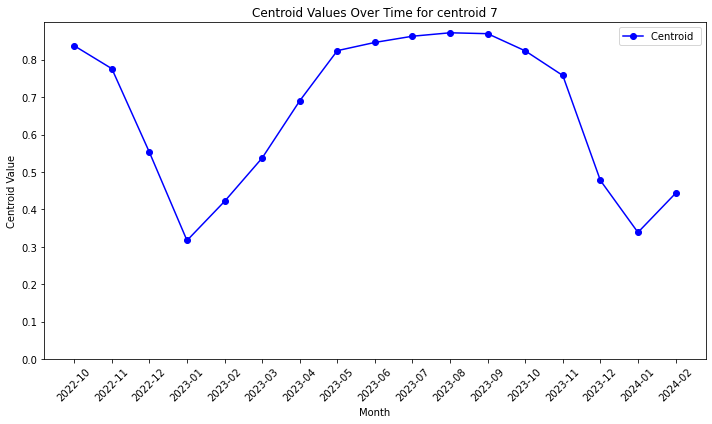

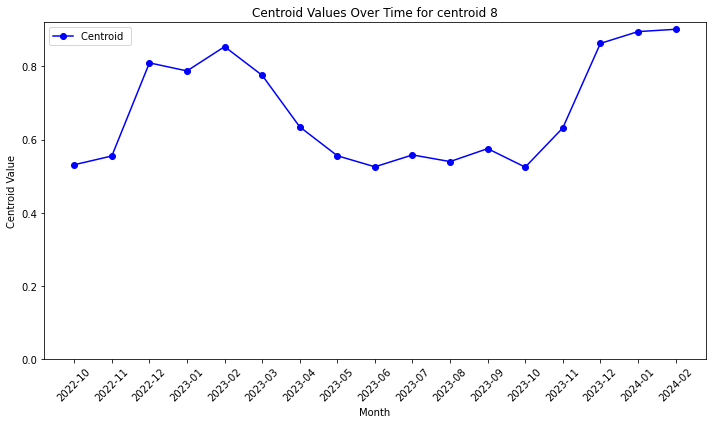

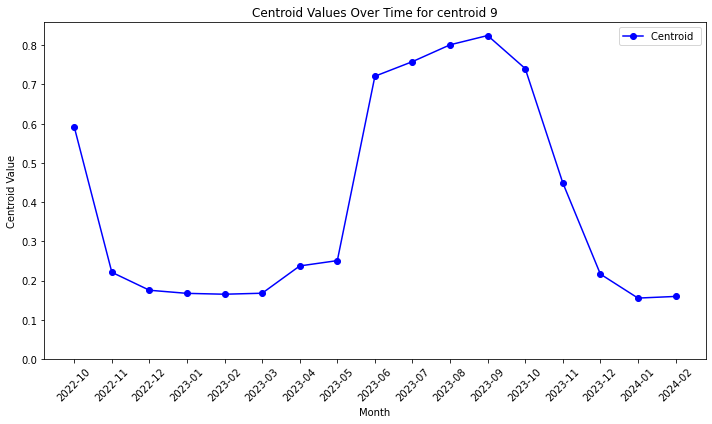

In [48]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance,TimeSeriesResampler
import multiprocessing

nb_clusters= ENV.max_nb_clusters
min_nb_in_cluster = ENV.min_nb_in_cluster
clustering_algorithm = ENV.clustering_algorithm
nb_cores=multiprocessing.cpu_count()


print("clusterizing step")

def clusterize_Kmeans(pivot_df_with_all_months, nb_clusters, min_size):
    print(f"clusterizing with clusterize_Kmeans, {nb_clusters} clusters")
    
    # Scale the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pivot_df_with_all_months)
    
    #clusterize
    kmeans = KMeans(n_clusters=nb_clusters,random_state=42)
    kmeans.fit(scaled_features)  # Ensure you fit the scaled features
    
    unique, counts = np.unique(kmeans.labels_, return_counts=True)
    cluster_sizes = dict(zip(unique, counts))

    # Identify clusters with less than min_size items
    small_clusters = [cluster_id for cluster_id, size in cluster_sizes.items() if size < min_size]
    print(small_clusters)
    # Filter out centroids of these small clusters
    centroids = kmeans.cluster_centers_
    filtered_centroids = np.array([centroids[i] for i in range(len(centroids)) if i not in small_clusters])
    
    #rescale
    cluster_centers = scaler.inverse_transform(filtered_centroids)
    return kmeans.labels_, cluster_centers

def clusterize_Agg(pivot_df_with_all_months, distance_threshold):
    print(f"Clusterizing with clusterize_Agg, {distance_threshold} distance_threshold.")
    
    # Scale the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(pivot_df_with_all_months)
    
    # Create a connectivity matrix
    connectivity = kneighbors_graph(scaled_features, n_neighbors=2, include_self=False)
    
    # Initialize and apply agglomerative clustering
    clustering_algo = AgglomerativeClustering(
        distance_threshold=distance_threshold, 
        n_clusters=None,
        linkage="ward", 
        connectivity=connectivity,
        compute_full_tree=True
    )
    
    # Fit the model and predict cluster assignments
    cluster_labels = clustering_algo.fit_predict(scaled_features)
    pivot_df_with_all_months['cluster'] = cluster_labels
    
    # Calculate the cluster centers as the mean of each cluster
    cluster_centers = pivot_df_with_all_months.groupby('cluster').mean()
    
    # Print outputs
    print("Cluster centers columns:")
    print(cluster_centers.columns)
    print("Cluster centers:")
    print(cluster_centers.values)
    return cluster_labels, cluster_centers.values

def clusterize_Dtw(pivot_df_with_all_months, n_clusters,n_jobs=1):
    seed=0
    print(pivot_df_with_all_months.shape)
    X_train = TimeSeriesScalerMeanVariance().fit_transform(pivot_df_with_all_months)
    dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed, n_jobs=n_jobs)
    y_pred = dba_km.fit_predict(X_train)
    return y_pred, dba_km.cluster_centers_

# clear in case we relaunch
print(pivot_df_with_all_months.columns)
pivot_df_with_all_months=drop_columns(pivot_df_with_all_months,['cluster'])

print(f'Clusterising with {clustering_algorithm}') 
      
if clustering_algorithm == "Kmeans":
    cluster_labels,cluster_centers=clusterize_Kmeans(pivot_df_with_all_months, nb_clusters,min_nb_in_cluster)
    cluster_file_name = 'kmeans_centroids_original_scale.npy'
elif clustering_algorithm == "Agg":
    cluster_file_name = 'agg_centroids_original_scale_'+str(ENV.max_deviance_agg)+'.npy'
    cluster_labels,cluster_centers=clusterize_Agg(pivot_df_with_all_months, ENV.max_deviance_agg)#40=>98 cluster with min 54
    
elif clustering_algorithm == "Dtw":
    cluster_labels,cluster_centers=clusterize_Dtw(pivot_df_with_all_months, 200, n_jobs = nb_cores -1)
    cluster_file_name = 'dtw_centroids_original_scale_200.npy'
else:
    raise Exception(f'Not implemented algorithm {clustering_algorithm}') 

print(f'nb centroids {len(cluster_centers)}')

cluster_counts = Counter(cluster_labels)
sorted_cluster_counts = sorted(cluster_counts.items(), key=lambda item: item[1])


#Saving in file
np.save(cluster_file_name, cluster_centers)
                
exclude_columns = ['cluster', 'MaxDistColumn', 'SignedMaxDistance', 'MaxDistance']
filtered_columns = [col for col in pivot_df_with_all_months.columns if col not in exclude_columns]


# Printing sorted counts
for cluster_id, count in sorted_cluster_counts:
    print(f"Cluster {cluster_id}: {count} Installations")
    
for i in range(0,min(len(cluster_centers),10)):
    plot_centroid(i,filtered_columns,cluster_centers)



## Then assign all Installations to clusters

In [49]:

# Assuming cluster_centers contains the centroids in their original scale
print("assigning all Installations to found cluster")



def squared_distance_to_centroid(row, centroid):
    # Calculate the sum of absolute differences, ignoring NaN values
    valid_indices = ~np.isnan(row)
    squared_differences = (row[valid_indices] - centroid[valid_indices]) ** 2
    #abs_differences = np.sum(np.abs(row[valid_indices] - centroid[valid_indices]))
    return np.sum(squared_differences)


# we take the sum of distances (squared) of each row point to its neighbouring (-1,0,+1) centroid points.
#Beware, centroid values are between 0 and 1. so taking x as month index is a mistake, hence the x_factor. 

def squared_distance_to_centroid_x_y(row, centroid):
    row = np.array(row)
    centroid = np.array(centroid)
    x_factor = 0.1
    valid_indices = ~np.isnan(row) #& ~np.isnan(centroid)

    total_min_distance = 0

    # Calculate distances from each valid row point to -1/+1 month centroid's points
    for index in np.where(valid_indices)[0]:
        row_value=row[index]
        # Creating the point (x, y) for the row where x is the index and y is the value
        row_point = np.array([index*x_factor, row_value])
        distances = []
        min_distance_to_one_point = float('inf')
        for c_index in range(max(0,index-1), min(index+2,len(centroid))):
            centroid_value = centroid[c_index]
            centroid_point = np.array([c_index*x_factor, centroid_value])
            
            # Euclidean distance calculation
            distance = np.linalg.norm(row_point - centroid_point)
            squared_distance = (row_point[0] - centroid_point[0])**2 + (row_point[1] - centroid_point[1])**2
            #min_distance_to_one_point= min(min_distance_to_one_point,distance)
        
        total_min_distance+=squared_distance#min_distance_to_one_point
    
    return total_min_distance

# Initialize a list to hold the cluster assignments
cluster_assignments = []
cluster_distances = []

nb_rows = len(pivot_df)
index=0


def assign_installations_to_clusters(pivot_df,cluster_centers,USE_X_Y_DISTANCE = False,regenerate=False):
    export_path = os.path.join(folder_path,data_paths['installation_cluster'])
    if os.path.isfile(export_path) and not regenerate:
        cluster_df = pd.read_csv(export_path,low_memory=False)
        return cluster_df
    
    pivot_df = drop_columns(pivot_df,['cluster'])
    used_distance = squared_distance_to_centroid

    if USE_X_Y_DISTANCE is True:
        used_distance=squared_distance_to_centroid_x_y

    # Iterate over each row in pivot_df
    for _, row in pivot_df.iterrows():
        row_values = row.values  # Convert the row to a NumPy array for easier element-wise operations
        min_distance = float('inf')
        cluster = -1
        cluster_index = 0
        index +=1
        #if index%1000 ==0:
        #    print(f"index {index} out of {nb_rows}")

        # Iterate over each centroid to find the closest one
        for centroid in cluster_centers:
            distance = used_distance(row_values, centroid)
            if distance < min_distance:
                min_distance = distance
                cluster = cluster_index
            cluster_index += 1

        # Assign the closest cluster to the row
        cluster_distances.append(min_distance)
        cluster_assignments.append(cluster)

    # Assign the cluster assignments back to the DataFrame
    pivot_df['cluster'] = cluster_assignments
    pivot_df['distance_to_cluster'] = cluster_distances

    cluster_df = pivot_df.reset_index()
    cluster_df = cluster_df[['Installation', 'cluster']]

    dataframe_to_csv(cluster_df, data_paths['installation_cluster'])
    return cluster_df

cluster_df = assign_installations_to_clusters(pivot_df,cluster_centers)

def get_installations_in_cluster(cluster_id):
    return cluster_df[cluster_df['cluster']==cluster_id]


    
print(pivot_df.head())


assigning all Installations to found cluster
month         2022-10  2022-11  2022-12  2023-01  2023-02  2023-03  2023-04  \
Installation                                                                  
292561           0.88     0.84     0.82     0.81     0.59     0.02     0.35   
292562           0.64     0.74     0.70     0.82     0.88     0.58     0.66   
292563           1.00     0.96     0.88     0.88     0.00     0.80     0.64   
292564           0.26     0.24     0.50     0.96     0.90     0.96     0.84   
292567           0.47     0.29     0.62     0.36     0.15     0.60     0.31   

month         2023-05  2023-06  2023-07  2023-08  2023-09  2023-10  2023-11  \
Installation                                                                  
292561           1.00     0.88     0.72     0.81     0.80     0.87     0.97   
292562           0.70     0.50     0.62     0.54     0.58     0.72     0.84   
292563           0.68     0.76     0.72     0.76     0.76     0.72     0.64   
292564

In [50]:
def most_common_value_and_share(series):
    # Count frequencies of each value in the column
    value_counts = series.value_counts(normalize=True)
    
    # Get the most common value and its frequency
    most_common = value_counts.idxmax()
    most_common_share = value_counts.max()
    
    # Format the share as a percentage
    most_common_share_percentage = "{:.2%}".format(most_common_share)
    
    return most_common, most_common_share_percentage

def top_5_common_values_and_shares(series):
    value_counts = series.value_counts(normalize=True)
    top_5 = value_counts.head(5)
    top_5_percentage = top_5.apply(lambda x: "{:.2%}".format(x))
    result_df = pd.DataFrame({
        'Value': top_5.index,
        'Share': top_5_percentage
    }).reset_index(drop=True)
    
    return result_df

def get_information_from_cluster(pa_df,cluster_id):
    filter = get_installations_in_cluster(cluster_id)
    installations = filter['Installation'].unique()
    print(len(installations))
    df = pa_df[pa_df['Installation'].isin(installations)]
    df['Reduced_NAF'] = df['Code_NAF'].str.slice(0, 3)
    nb_NAF = df['Reduced_NAF'].nunique()
    nb_REGION = df['REGION'].nunique()
    
    code_naf_common = top_5_common_values_and_shares(df['Reduced_NAF'])
    print (code_naf_common)
    print(f" out of {nb_NAF} NAF Values in cluster")
    region_common = top_5_common_values_and_shares(df['REGION'])
    print(region_common)
    print(f"out of {nb_REGION} REGIONs Values in cluster")

#get_information_from_cluster(aggregated_df_per_month,42)

# Configuration test

In [51]:
print(aggregated_df_per_month.columns)
# add reduced NAF
aggregated_df_per_month['Reduced_NAF'] = aggregated_df_per_month['Code_NAF'].str.slice(0, 3)
aggregated_df_per_month = pd.merge(aggregated_df_per_month, cluster_df, on='Installation', how='left')
print(aggregated_df_per_month.head(5))


Index(['Installation', 'month', 'PAInstallationMonth', 'PSInstallationMonth',
       'Code_NAF', 'REGION', 'maxPAInstallation', 'maxPSInstallation',
       'maxPANormalized', 'maxPSNormalized', 'PA_div_PS_Normalized',
       'PS_Normalized', 'ratio_cluster'],
      dtype='object')
   Installation    month  PAInstallationMonth  PSInstallationMonth Code_NAF  \
0        292561  2022-10                95.00                95.00    9601B   
1        292561  2022-11                91.00                95.00    9601B   
2        292561  2022-12                89.00                95.00    9601B   
3        292561  2023-01                88.00                95.00    9601B   
4        292561  2023-02                64.00                95.00    9601B   

  REGION  maxPAInstallation  maxPSInstallation  maxPANormalized  \
0    211             108.00              95.00             0.88   
1    211             108.00              95.00             0.84   
2    211             108.00              9

In [71]:

# compute configuration clusters


def compute_configuration_labels(pivot_table):
# Compute the dot product matrix
    dot_product_matrix = np.dot(pivot_table, pivot_table.T)

    # Convert similarities (dot product) to distances
    max_dot = np.max(dot_product_matrix)
    distance_matrix = max_dot - dot_product_matrix

    # Convert the distance matrix to a similarity matrix by inversing the distances
    similarity_matrix = 1 / (1 + distance_matrix)

    # Perform clustering 
    clustering = AgglomerativeClustering(linkage='ward', distance_threshold=30, n_clusters=None)
    labels = clustering.fit_predict(similarity_matrix)
    return labels
    

def get_configuration_clusters(aggregated_df_per_month,regenerate=False):
    print("get_configuration_clusters")
    export_path = os.path.join(folder_path,data_paths['configuration_cluster'])
    pivot_df = aggregated_df_per_month.pivot(index='Installation', columns='month', values='ratio_cluster')
    if os.path.isfile(export_path) and not regenerate:
        cluster_assignments = pd.read_csv(export_path,low_memory=False)
        return cluster_assignments
    
    nb_Installation_per_Configuration = aggregated_df_per_month.groupby(['Reduced_NAF','REGION']).size().reset_index(name='nb_per_config')
    cluster_counts = aggregated_df_per_month.groupby(['Reduced_NAF','REGION', 'cluster']).size().reset_index(name='nb_installations')

    print(nb_Installation_per_Configuration.head(5))
    print(cluster_counts.head(5))

    # Group by Reduced_NAF and REGION to sum installations
    total_installations = cluster_counts.groupby(['Reduced_NAF', 'REGION'])['nb_installations'].sum().reset_index(name='Total_installations')

    # Merge this back to the original dataframe to have the total per Reduced_NAF and REGION
    cluster_counts = pd.merge(cluster_counts, total_installations, on=['Reduced_NAF', 'REGION'])

    # Calculate the proportion
    cluster_counts['proportion_Installations_in_cluster'] = cluster_counts['nb_installations'] / cluster_counts['Total_installations']
    print(cluster_counts.head(5))

    cluster_counts['Configuration'] = cluster_counts['Reduced_NAF'] + "_" + cluster_counts['REGION']
    # Create pivot table
    pivot_table = pd.pivot_table(cluster_counts, values='proportion_Installations_in_cluster', index='Configuration', columns='cluster', aggfunc='sum')
    pivot_table=pivot_table.fillna(0)
    
    labels = compute_configuration_labels(pivot_table)
    configurations = pivot_table.index.tolist()
    cluster_assignments = pd.DataFrame({
        'Configuration': configurations,
        'Cluster_Label': labels
    })
    dataframe_to_csv(cluster_assignments, data_paths['configuration_cluster'])
    return cluster_assignments


cluster_assignments= get_configuration_clusters(aggregated_df_per_month)
print(cluster_assignments.head())

#proportions


get_configuration_clusters
  Reduced_NAF REGION  nb_per_config
0         000    125             17
1         011    01A           2453
2         011    01B            507
3         011    07E             17
4         011    07F             17
  Reduced_NAF REGION  cluster  nb_installations
0         000    125       94                17
1         011    01A        0                17
2         011    01A        4                34
3         011    01A        7                33
4         011    01A        9                34
  Reduced_NAF REGION  cluster  nb_installations  Total_installations  \
0         000    125       94                17                   17   
1         011    01A        0                17                 2453   
2         011    01A        4                34                 2453   
3         011    01A        7                33                 2453   
4         011    01A        9                34                 2453   

   proportion_Installations_in_clust

In [65]:

def get_configuration_info(cluster_assignments,cluster_id):
    return cluster_assignments[cluster_assignments['Cluster_Label']==cluster_id]


cluster_info= get_configuration_info(cluster_assignments,34)
print(cluster_info)

unique_cluster_counts = cluster_assignments.groupby('Cluster_Label')['Configuration'].nunique()
print(unique_cluster_counts)
    

Index(['Installation', 'month', 'PAInstallationMonth', 'PSInstallationMonth',
       'Code_NAF', 'REGION', 'maxPAInstallation', 'maxPSInstallation',
       'maxPANormalized', 'maxPSNormalized', 'PA_div_PS_Normalized',
       'PS_Normalized', 'ratio_cluster', 'Reduced_NAF', 'cluster'],
      dtype='object')
      Configuration  Cluster_Label
0           000_125             34
437         022_125             34
449         022_179             34
469          022_57             34
571         081_124             34
...             ...            ...
13565       932_07O             34
13887       951_162             34
13891       951_21D             34
13967       960_175             34
14018        960_51             34

[204 rows x 2 columns]
Cluster_Label
0     7037
1      827
2      817
3      748
4      933
5       60
6       59
7      331
8      312
9       95
10     215
11      96
12     205
13     134
14      59
15     123
16      55
17      83
18     148
19      42
20      64
21 

In [86]:
# now I have configurations
# So I start from scratch. 
# For each configuration, I redo the clustering

def get_installations_infos(aggregated_df_per_month):
    df_without_month= drop_columns(aggregated_df_per_month,['month'])
    final_df = df_without_month.groupby('Installation').first().reset_index()
    return final_df

#installations_df = get_installations_infos(aggregated_df_per_month)
#installations_df = drop_columns(installations_df,['PAInstallationMonth','PSInstallationMonth','maxPAInstallation', 'maxPSInstallation','maxPANormalized', 'maxPSNormalized','PA_div_PS_Normalized','PS_Normalized', 'ratio_cluster'])
aggregated_df_per_month = drop_columns(aggregated_df_per_month,['Cluster_Label','Cluster_Label_x','Cluster_Label_y'])
aggregated_df_per_month['Configuration']= aggregated_df_per_month['Reduced_NAF']+"_"+aggregated_df_per_month['REGION']
aggregated_df_per_month=pd.merge(aggregated_df_per_month,cluster_assignments,on=['Configuration'])

unique_configurations_clusters = cluster_assignments['Cluster_Label'].unique()
cluster_labels_array=[]
cluster_centers_array=[]
for configuration_cluster in unique_configurations_clusters:
    print(f'testing configuration_cluster:{configuration_cluster}')
    filtered_df=aggregated_df_per_month[aggregated_df_per_month['Cluster_Label']==configuration_cluster]
    cluster_file_name = 'agg_centroids_original_scale_'+str(ENV.max_deviance_agg)+'.npy'
    pivot_df_with_all_months_filtered = filtered_df.pivot(index='Installation', columns='month', values='ratio_cluster')
    #pivot_df_with_all_months_filtered.fillna(0)
    pivot_df_with_all_months_filtered= pivot_df_with_all_months_filtered.dropna().copy()
    print(f'Total number installations in pivot table {len(pivot_df_with_all_months_filtered)}')
    cluster_labels,cluster_centers=clusterize_Agg(pivot_df_with_all_months_filtered, ENV.max_deviance_agg)
    cluster_labels_array.append(cluster_labels)
    cluster_centers_array.append(cluster_centers)

print("clustering done")
    
    


testing configuration_cluster:34
Total number installations in pivot table 65
Clusterizing with clusterize_Agg, 30 distance_threshold.
Cluster centers columns:
Index(['2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
       '2023-10', '2023-11', '2023-12', '2024-01', '2024-02'],
      dtype='object', name='month')
Cluster centers:
[[0.94243756 0.94924136 0.967825   0.95846976 0.95985191 0.96893197
  0.95012874 0.93417678 0.94227293 0.94101596 0.92953578 0.9397096
  0.93977551 0.94574255 0.95499963 0.93749759 0.95442752]]
testing configuration_cluster:0


/Users/michaelargi/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:280: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


Total number installations in pivot table 60776
Clusterizing with clusterize_Agg, 30 distance_threshold.


/Users/michaelargi/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:280: UserWarning: the number of connected components of the connectivity matrix is 32 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


Cluster centers columns:
Index(['2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
       '2023-10', '2023-11', '2023-12', '2024-01', '2024-02'],
      dtype='object', name='month')
Cluster centers:
[[0.65958688 0.42127998 0.39124358 ... 0.36618688 0.35652307 0.38183571]
 [0.41315028 0.4425098  0.60607095 ... 0.72652723 0.83645569 0.89151684]
 [0.6634647  0.68202701 0.89434353 ... 0.88571139 0.90099768 0.90065919]
 ...
 [0.58379063 0.66122672 0.92964564 ... 0.74538301 0.70242674 0.7188091 ]
 [0.11458305 0.78140997 0.91145592 ... 0.89187284 0.87736231 0.87990186]
 [0.33324326 0.14995511 0.12556535 ... 0.13246488 0.11506622 0.11692747]]
testing configuration_cluster:35
Total number installations in pivot table 66
Clusterizing with clusterize_Agg, 30 distance_threshold.
Cluster centers columns:
Index(['2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-0

/Users/michaelargi/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:280: UserWarning: the number of connected components of the connectivity matrix is 4 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


Cluster centers columns:
Index(['2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
       '2023-10', '2023-11', '2023-12', '2024-01', '2024-02'],
      dtype='object', name='month')
Cluster centers:
[[0.82017184 0.78975429 0.75750919 0.74216429 0.73308725 0.7425691
  0.73792385 0.77018268 0.83564004 0.90405198 0.91285968 0.93393838
  0.85501306 0.77782967 0.76708538 0.77179205 0.77435724]
 [0.48033679 0.53706351 0.83264991 0.84938051 0.90547479 0.82638327
  0.67691405 0.54849898 0.44807439 0.45020277 0.43651157 0.45182644
  0.43995935 0.55186305 0.73465484 0.76147905 0.78492978]
 [0.47622047 0.45134474 0.46508707 0.42271441 0.42753039 0.43228024
  0.43251267 0.4620943  0.40899815 0.45788854 0.45754023 0.50695691
  0.45652356 0.51665255 0.60171431 0.59301096 0.58698989]
 [0.79035022 0.80448419 0.89822684 0.89771893 0.92279202 0.89261242
  0.82884404 0.77306363 0.78158047 0.79584778 0.78188587 0.80718

/Users/michaelargi/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:280: UserWarning: the number of connected components of the connectivity matrix is 7 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


Cluster centers columns:
Index(['2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
       '2023-10', '2023-11', '2023-12', '2024-01', '2024-02'],
      dtype='object', name='month')
Cluster centers:
[[0.47970188 0.50431716 0.50532334 0.50362803 0.45578723 0.47339623
  0.44386352 0.5153985  0.60027555 0.5928996  0.6022333  0.6202047
  0.56812382 0.57876564 0.51240821 0.54597317 0.55305703]
 [0.67142055 0.6898079  0.71523603 0.68685368 0.69258032 0.69787436
  0.70058132 0.6700699  0.63791982 0.67389601 0.66217026 0.69027961
  0.67888858 0.72184729 0.75566006 0.6868092  0.70908613]
 [0.81079603 0.84406349 0.86952687 0.84917512 0.81232323 0.75979985
  0.69335027 0.58797221 0.53869199 0.49416726 0.41397301 0.4442861
  0.42262036 0.42827549 0.43360472 0.41081739 0.46426162]
 [0.81116341 0.79687271 0.83107464 0.82489885 0.83032386 0.82570027
  0.81419149 0.80937582 0.8181755  0.81744302 0.80044274 0.804213

/Users/michaelargi/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:280: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


Cluster centers columns:
Index(['2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
       '2023-10', '2023-11', '2023-12', '2024-01', '2024-02'],
      dtype='object', name='month')
Cluster centers:
[[0.79544147 0.80373833 0.86828387 0.84131112 0.87032904 0.85668653
  0.81387762 0.78306631 0.7906438  0.80089382 0.77442268 0.77748136
  0.7753773  0.78989193 0.81791543 0.80486167 0.79423463]
 [0.53008298 0.48590312 0.49068343 0.61948318 0.6031722  0.58160806
  0.49692226 0.48909601 0.57332885 0.63425502 0.64441212 0.68931045
  0.61348559 0.63691039 0.6315309  0.72704674 0.73411768]
 [0.60684085 0.65018049 0.8693222  0.86085815 0.90770578 0.82824447
  0.71643864 0.60256004 0.48175864 0.46570185 0.432737   0.48408745
  0.50724443 0.6654687  0.78941058 0.84135788 0.80455059]
 [0.90849478 0.90973789 0.92382478 0.91001312 0.91876329 0.91787435
  0.91114955 0.90737548 0.90517957 0.91730986 0.90447937 0.9091

/Users/michaelargi/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:280: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


Cluster centers columns:
Index(['2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
       '2023-10', '2023-11', '2023-12', '2024-01', '2024-02'],
      dtype='object', name='month')
Cluster centers:
[[0.406898   0.41097531 0.4744665  0.53240228 0.61807151 0.60226335
  0.57697944 0.56649283 0.56310088 0.61588335 0.57410377 0.61737303
  0.64695201 0.75246347 0.77455162 0.8227284  0.83802328]
 [0.80573607 0.80246124 0.86754906 0.8630721  0.87450874 0.85224451
  0.82178267 0.79168337 0.78030056 0.76610673 0.7506641  0.77043217
  0.78426841 0.81797213 0.86691574 0.86800329 0.86245964]
 [0.26474842 0.17772049 0.07474625 0.10805987 0.08673156 0.12364098
  0.08382144 0.07921602 0.1602297  0.31139438 0.32803263 0.36034894
  0.2270712  0.15460212 0.24212657 0.29469776 0.40476861]
 [0.7687647  0.63819795 0.60424916 0.56323589 0.56633257 0.56521545
  0.60698871 0.65154959 0.7855129  0.79546634 0.74285163 0.7755

/Users/michaelargi/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:280: UserWarning: the number of connected components of the connectivity matrix is 9 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


Cluster centers columns:
Index(['2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
       '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09',
       '2023-10', '2023-11', '2023-12', '2024-01', '2024-02'],
      dtype='object', name='month')
Cluster centers:
[[0.80956567 0.8140429  0.80146693 0.76960252 0.77819655 0.75068964
  0.75223484 0.73369578 0.74030104 0.70422247 0.64712906 0.63767583
  0.6361727  0.63594089 0.61516809 0.59556388 0.60600168]
 [0.52737254 0.61225467 0.88992498 0.86740151 0.89709022 0.84056123
  0.70818918 0.58596892 0.4513711  0.40269529 0.39382611 0.4168077
  0.46351563 0.66333045 0.81253686 0.85629293 0.82412673]
 [0.82930033 0.81969245 0.84753879 0.79886881 0.8011081  0.79042658
  0.77143165 0.73430286 0.74530538 0.7621334  0.74678981 0.75615406
  0.77580065 0.78990824 0.8000606  0.80424277 0.79331591]
 [0.12631789 0.10993201 0.07214612 0.08810777 0.1708538  0.10784871
  0.25241692 0.2238164  0.30763217 0.45748578 0.43657956 0.50443

/Users/michaelargi/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:280: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(


In [ ]:
'''
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Calculate the condensed distance matrix, which is needed for hierarchical clustering
condensed_dist_matrix = ssd.squareform(distance_matrix)

# Generate the linkage matrix
linkage_matrix = sch.linkage(condensed_dist_matrix, method='complete')

# Optionally plot a dendrogram to help decide a suitable threshold
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Configurations')
plt.ylabel('Distance')
plt.show()

# Decide on a threshold from the dendrogram and form flat clusters
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(linkage_matrix, t=1.5, criterion='distance')
'''

# Find outliers

In [ ]:
print("looking four outliers")
pivot_df['cluster'] = pivot_df['cluster'].astype(int)

'''
rows_with_nan = pivot_df[pivot_df.isna().any(axis=1)]
for index, row in rows_with_nan.iterrows():
    print("Index:", index)
    print("Values:", row.values)

print(len(rows_with_nan))
print(rows_with_nan.head(2))
'''


def calculate_distances(row, cluster_centers, pivot_df):
    cluster = int(row['cluster'])
    centroid = cluster_centers[cluster]
    # Exclude the cluster label from row values and ensure dimensions match
    values = row.drop('cluster')  # Directly drop 'cluster' to avoid dimensional mismatch
    
    # Check if centroids have valid data
    if np.any(np.isnan(centroid)):
        print("Centroid contains NaN values which may cause errors in distance calculations.")
    
    # Compute valid indices for non-NaN values
    valid_indices = ~np.isnan(values)
    valid_indices["cluster"]=False
    
    centroid= np.append(centroid,[0])
    # Ensure valid_indices and centroid have matching dimensions
    valid_centroid = centroid[valid_indices]
    valid_values = values[valid_indices]
    
    if valid_values.size > 0:
        distances = valid_values - valid_centroid
        max_abs_distance_index = np.argmax(np.abs(distances))
        signed_max_distance = distances[max_abs_distance_index]
        
        # Properly access the column names using valid indices
        valid_columns = pivot_df.columns[valid_indices]
        max_distance_column = valid_columns[max_abs_distance_index]
    else:
        print(cluster)
        print(values)
        print(centroid)
        max_distance_column = 'None'
        signed_max_distance = np.nan
        print("All values are NaN or centroid is not defined.")
    
    return pd.Series([max_distance_column, signed_max_distance], index=['MaxDistColumn', 'SignedMaxDistance'])
    
print("firing")
print(cluster_centers)
print(pivot_df.head(2))
#reset in case we restart not from scratch
columns_to_delete = ['MaxDistColumn','SignedMaxDistance','MaxDistance','distance_to_cluster']
pivot_df = drop_columns(pivot_df,columns_to_delete)

# Apply the modified function to each row and assign the results to new columns
pivot_df[['MaxDistColumn', 'SignedMaxDistance']] = pivot_df.apply(lambda row: calculate_distances(row, cluster_centers, pivot_df), axis=1)
pivot_df['MaxDistance'] = pivot_df['SignedMaxDistance'].abs()

# Now, sort pivot_df by 'MaxDistance' in descending order to see the most anomalous entries first
pivot_df_sorted = pivot_df.sort_values(by='MaxDistance', ascending=False)



pivot_to_csv(pivot_df_sorted, data_paths['pivot_ouliers'])


#only the ones with PA > centroid
pivot_df_sorted_and_filtered_UP = pivot_df_sorted[pivot_df_sorted['SignedMaxDistance']>0]
#only the ones with PA > centroid
pivot_df_sorted_and_filtered = pivot_df_sorted[pivot_df_sorted['SignedMaxDistance']<0]

print(pivot_df_sorted_and_filtered_UP.head())
#print(pivot_df_sorted_and_filtered.head())


In [ ]:
def plot_maxPA_maxPM_per_date_for_installation(df, installation,saveName=""):
    df_filtered = df[df['Installation'] == installation]
    plt.figure(figsize=(10, 6))
    plt.plot(df_filtered['month'], df_filtered['PAInstallationMonth'], marker='o', linestyle='-', label='maxPA')
    plt.plot(df_filtered['month'], df_filtered['PSInstallationMonth'], marker='x', linestyle='--', label='maxPS')

    # Formatting the plot
    plt.title(f'maxPA and maxPS per Month for Installation {installation}')
    plt.xlabel('Month')
    plt.ylabel('Value')
    plt.xticks(rotation=45)
    plt.legend()
    if saveName:
        plt.savefig(saveName)
        plt.close()
    else:
        plt.show()
        

#print(pivot_df_sorted_and_filtered.head())

#print(cluster_centers)

exclude_columns = ['cluster', 'MaxDistColumn', 'SignedMaxDistance', 'MaxDistance']
filtered_columns = [col for col in pivot_df.columns if col not in exclude_columns]

first_five_installations = pivot_df_sorted_and_filtered.index[:5]

#print(pivot_df_sorted_and_filtered.head(2))

for installation in first_five_installations:
    print(f"Found anomalies  {get_ANO_per_Installation(installation)}")
    print(aggregated_df_per_month[aggregated_df_per_month["Installation"]== installation].iloc[0])
    installation_cluster = pivot_df_sorted_and_filtered.loc[installation, 'cluster']
    
    installation_month = pivot_df_sorted_and_filtered.loc[installation, 'MaxDistColumn']
    print(f'Displaying Installation {installation} for month {installation_month} in cluster {installation_cluster}')

    plot_maxPA_maxPM_per_date_for_installation(aggregated_df_per_month,installation)
    plot_centroid(installation_cluster,filtered_columns,cluster_centers)
    plot_PA_per_date_for_installation(pa_df,installation)


In [ ]:

filtered_data = pa_df[(pa_df['Installation'] == 312378) & (pa_df['month'] == "2023-03")]

print(filtered_data)

In [ ]:
first_five_installations = pivot_df_sorted_and_filtered_UP.index[:5]

for installation in first_five_installations:
    installation_cluster = pivot_df_sorted_and_filtered_UP.loc[installation, 'cluster']
    installation_month = pivot_df_sorted_and_filtered_UP.loc[installation, 'MaxDistColumn']
    print(f'Displaying Installation {installation} for month {installation_month} in cluster {installation_cluster}')
    print(aggregated_df_per_month[aggregated_df_per_month["Installation"]== installation].iloc[0])
    plot_maxPA_maxPM_per_date_for_installation(aggregated_df_per_month,installation)
    plot_centroid(installation_cluster,filtered_columns,cluster_centers)
    plot_PA_per_date_for_installation(pa_df,installation)

In [ ]:
install = get_installations_in_cluster(21)
print(install.head(5))

plot_PA_per_date_for_installation(pa_df,292578)
print(pa_df[pa_df['Installation']==292578])
plot_PA_per_date_for_installation(pa_df,292895)
plot_PA_per_date_for_installation(pa_df,293050)

In [ ]:
292578